In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
eventos = pd.read_pickle("./datasets/evento.pkl")
acessos = pd.read_pickle("./datasets/acesso.pkl")

In [3]:
consumidor_evento = eventos.groupby("id_consumidor_ecommerce").agg({
    "id_evento" : "count",
    "preco" : "sum",
}).reset_index()

consumidor_acessos = acessos.groupby("id_consumidor_ecommerce").agg({ "id_acessos": "count" }).reset_index()

In [4]:
vendas_acessos = consumidor_evento.join(
    consumidor_acessos.set_index("id_consumidor_ecommerce"), on = "id_consumidor_ecommerce", lsuffix="_e", rsuffix="_a", how = "inner"
).reset_index()
vendas_acessos.rename(columns = { "id_evento": "count_compras", "preco": "sum_preco", "id_acessos": "count_acessos" }, inplace=True)

In [5]:
features = vendas_acessos[["count_compras", "sum_preco", "count_acessos"]]

In [6]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features.fillna(method="ffill"))

## Modelo de clusterização 

### Metricas para definir o número de clusters

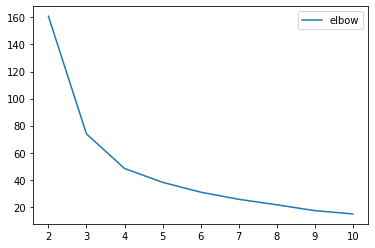

In [7]:
sse = []
silhouette_coefficients = []
k_axis = range(2, 11)
for k in k_axis:
    kmeans = KMeans(random_state=42, n_clusters=k)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

scores = pd.DataFrame(index=k_axis, data={"elbow": sse})
sns.lineplot(data= scores)
plt.show()

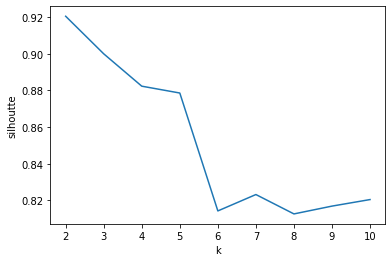

In [8]:
ax = sns.lineplot(data = {"k": k_axis, "silhoutte": silhouette_coefficients}, x="k", y = "silhoutte")
plt.show()

### Modelo resultante

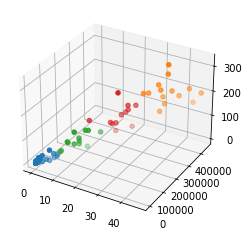

In [9]:
kmeans = KMeans(random_state=42, n_clusters=4)
kmeans.fit(scaled_features)

fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
labels = kmeans.labels_
u_labels = np.unique(labels)
for cluster in u_labels:
    ax.scatter(features.iloc[labels == cluster, 0], features.iloc[labels == cluster, 1], 
        features.iloc[labels == cluster, 2])
plt.show()

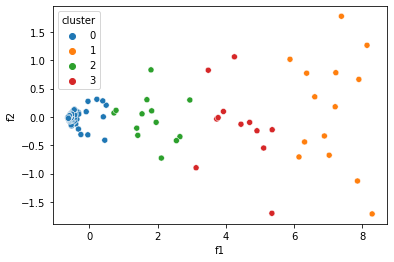

In [10]:
pca = PCA(n_components = 2)
principal_features = pca.fit_transform(scaled_features)
p_features = pd.DataFrame(data = principal_features, columns = ['f1', 'f2'])
p_features = p_features.assign(cluster = labels).astype({'cluster': 'category'})
sns.scatterplot(data = p_features, x = "f1", y="f2", hue = "cluster")
plt.show()

In [11]:
features = features.assign(cluster = labels)

In [12]:
from pathlib import Path
p = Path("pre_processed_data")
p.mkdir(parents = True, exist_ok = True)
features.to_pickle("./pre_processed_data/decision_tree")

In [13]:
vendas_acessos.drop(columns=["index"], inplace=True)

In [14]:
vendas_acessos = vendas_acessos.assign(cluster = labels)

In [15]:
count_compras = vendas_acessos[["id_consumidor_ecommerce", "count_compras", "cluster"]]
count_compras["type"] = "count_compras"
count_compras.rename(columns={"count_compras": "value"}, inplace=True)

sum_preco = vendas_acessos[["id_consumidor_ecommerce", "sum_preco", "cluster"]]
sum_preco["type"] = "sum_preco"
sum_preco.rename(columns={"sum_preco": "value"}, inplace=True)

count_acessos = vendas_acessos[["id_consumidor_ecommerce", "count_acessos", "cluster"]]
count_acessos["type"] = "count_acessos"
count_acessos.rename(columns={"count_acessos": "value"}, inplace=True)

In [16]:
personas = pd.concat([count_compras, sum_preco, count_acessos])

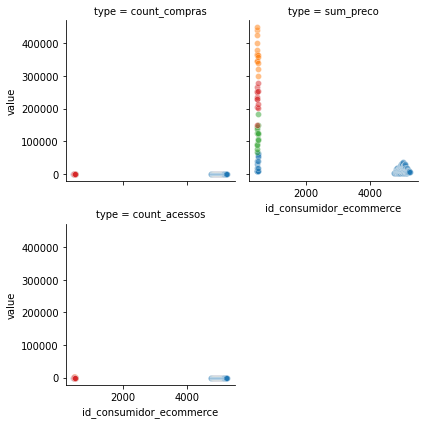

In [17]:
grid = sns.FacetGrid(personas, col="type", hue="cluster", col_wrap=2)
grid.map(sns.scatterplot, "id_consumidor_ecommerce", "value", alpha = .5)
plt.show()

In [18]:
consumidor_info = eventos.groupby("id_consumidor_ecommerce").agg({"sexo": "min", "faixa_etaria": "min"}).reset_index()
acessos_info = acessos.groupby("id_consumidor_ecommerce").agg({"uf": "min", "cidade": "min"})

In [19]:
consumidores = consumidor_info.join(acessos_info, on="id_consumidor_ecommerce", how = "inner")

In [20]:
consumidores = consumidores.join(
    vendas_acessos[["id_consumidor_ecommerce", "cluster"]].set_index("id_consumidor_ecommerce"),
    on = "id_consumidor_ecommerce", how = "inner"
)

In [21]:
consumidores.to_pickle("./pre_processed_data/consumidores_cluster.pkl")